### This code is inspired by the following  [paper](https://arxiv.org/pdf/2007.13224.pdf) 

In [ ]:
!pip install nibabel

In [ ]:
import os
import zipfile
import numpy as np
import nibabel as nib
import tensorflow as tf

In [ ]:
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(os.getcwd(), "CT-0.zip")
tf.keras.utils.get_file(filename, url)

url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename = os.path.join(os.getcwd(), "CT-23.zip")
tf.keras.utils.get_file(filename, url)

1045168128/1045162547 [==============================] - 16s 0us/step


'/content/CT-23.zip'

In [ ]:
os.makedirs("MosMedData")

with zipfile.ZipFile('CT-0.zip', 'r') as z_fp:
  z_fp.extractall("./MosMedData/")

with zipfile.ZipFile('CT-23.zip', 'r') as z_fp:
  z_fp.extractall("./MosMedData/")

**CT scans** store raw voxel intensity in Hounsfield units (HU). They range from -1024 to above 2000 in this dataset. Above 400 are bones with different radiointensity, so this is used as a higher bound. A threshold between -1000 and 400 is commonly used to normalize CT scans.

To process the data, we do the following:
*   We first rotate the volumes by 90 degrees, so the orientation is fixed
*   We resize width, height and depth. 
*  We scale the HU values to be between 0 and 1



In [ ]:
from scipy import ndimage

def read_nifti_file(filepath):
  scan = nib.load(filepath)
  scan = scan.get_fdata()
  
  return scan

def normalize(volume):
  min = -1000
  max = 400
  volume[volume>max] = max
  volume[volume<min] = min
  volume = (volume-min)/(max-min)
  
  return volume.astype(np.float32)

def resize_volume(img):
  desired_depth = 64
  desired_height = 128
  desired_width = 128

  current_depth = img.shape[-1]
  current_width = img.shape[0]
  current_height = img.shape[1]

  depth_factor = desired_depth/current_depth ## possible changes ##
  height_factor = desired_height/current_height
  width_factor = desired_width/current_width

  img = ndimage.rotate(img, 90, reshape=False)
  img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
  
  return img

def process_scan(path):
  volume = read_nifti_file(path)
  volume = normalize(volume)
  volume = resize_volume(volume)

  return volume

### Folder "CT-0" consist of CT scans having normal lung tissue, no CT-signs of viral pneumonia.

### Folder "CT-23" consist of CT scans having several ground-glass opacifications, involvement of lung parenchyma.

In [ ]:
normal_scan_path = [
                    os.path.join(os.getcwd(), 'MosMedData/CT-0', x)
                    for x in os.listdir('MosMedData/CT-0')
]

abnormal_scan_path = [
                    os.path.join(os.getcwd(), 'MosMedData/CT-23', x)
                    for x in os.listdir('MosMedData/CT-23')
]

print("CT scans with normal lung tissue", len(normal_scan_path))
print("CT scans with abnormal lung tissue", len(abnormal_scan_path))

CT scans with normal lung tissue 100
CT scans with abnormal lung tissue 100


In [ ]:
np.zeros((5,), dtype=np.int)

array([0, 0, 0, 0, 0])

In [ ]:
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_path])
abnormal_labels = np.ones((abnormal_scans.shape[0], ), dtype=np.int)

normal_scans = np.array([process_scan(path) for path in normal_scan_path])
normal_labels = np.zeros((normal_scans.shape[0], ), dtype=np.int)

x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)

x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)

print('number of samples in train and validation are %d and %d' % (x_train.shape[0], x_val.shape[0]))
print('number of labels in train are %d' % (y_train.shape))

number of samples in train and validation are 140 and 60
number of labels in train are 140


In [ ]:
np.save('MosMedData/x_train', x_train)
np.save('MosMedData/x_val', x_val)

In [ ]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        img = volume
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [ ]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(val_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the ct scan is:  (128, 128, 64, 1)


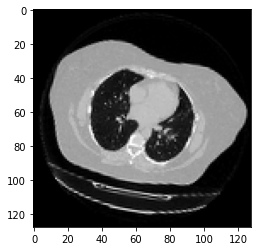

In [ ]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
image = images[0]
print("Dimension of the ct scan is: ", image.shape)
plt.imshow(np.squeeze(image[:,:,30]), cmap='gray')

In [ ]:
image.shape

TensorShape([128, 128, 64, 1])

In [15]:
def plot_slices2(num_rows, num_cols, image):
  height, width = image.shape[0], image.shape[1]
  fig_width = 16.0
  fig_height = fig_width * num_rows / num_cols
  fig = plt.figure(figsize=(fig_width, fig_height))
  for i in range(1, num_rows*num_cols +1 ):
    ax = fig.add_subplot(num_rows, num_cols, i)
    ax.imshow(np.array(image[:,:,i-1]).reshape(width,height), cmap='gray')
    ax.axis('off')

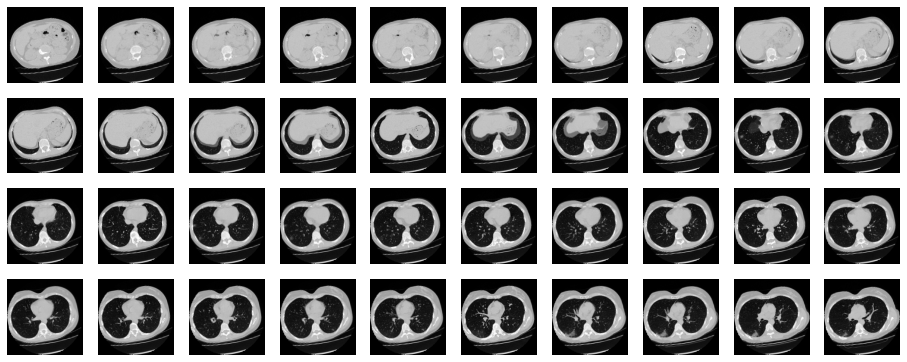

In [ ]:
plot_slices2(4, 10, image[:,:,:40])

In [ ]:
from tensorflow.keras.layers import Conv3D, MaxPool3D, BatchNormalization, GlobalAveragePooling3D, Dense, Dropout
from keras.utils.vis_utils import plot_model
def get_model(width=128, height=128, depth=64):
  inputs = tf.keras.Input((width, height, depth, 1))
  x = Conv3D(filters=64, kernel_size=3, activation='relu')(inputs)
  x = MaxPool3D(pool_size=2)(x)
  x = BatchNormalization()(x)

  x = Conv3D(filters=64, kernel_size=3, activation='relu')(x)
  x = MaxPool3D(pool_size=2)(x)
  x = BatchNormalization()(x)

  x = Conv3D(filters=128, kernel_size=3, activation='relu')(x)
  x = MaxPool3D(pool_size=2)(x)
  x = BatchNormalization()(x)

  x = Conv3D(filters=256, kernel_size=3, activation='relu')(x)
  x = MaxPool3D(pool_size=2)(x)
  x = BatchNormalization()(x)

  x = GlobalAveragePooling3D()(x)
  X = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)

  outputs = Dense(1, activation='sigmoid')(x)

  model = tf.keras.Model(inputs, outputs, name='3D_CNN')
  print(model.summary())

  return model

Model: "3D_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 14, 64)    256  

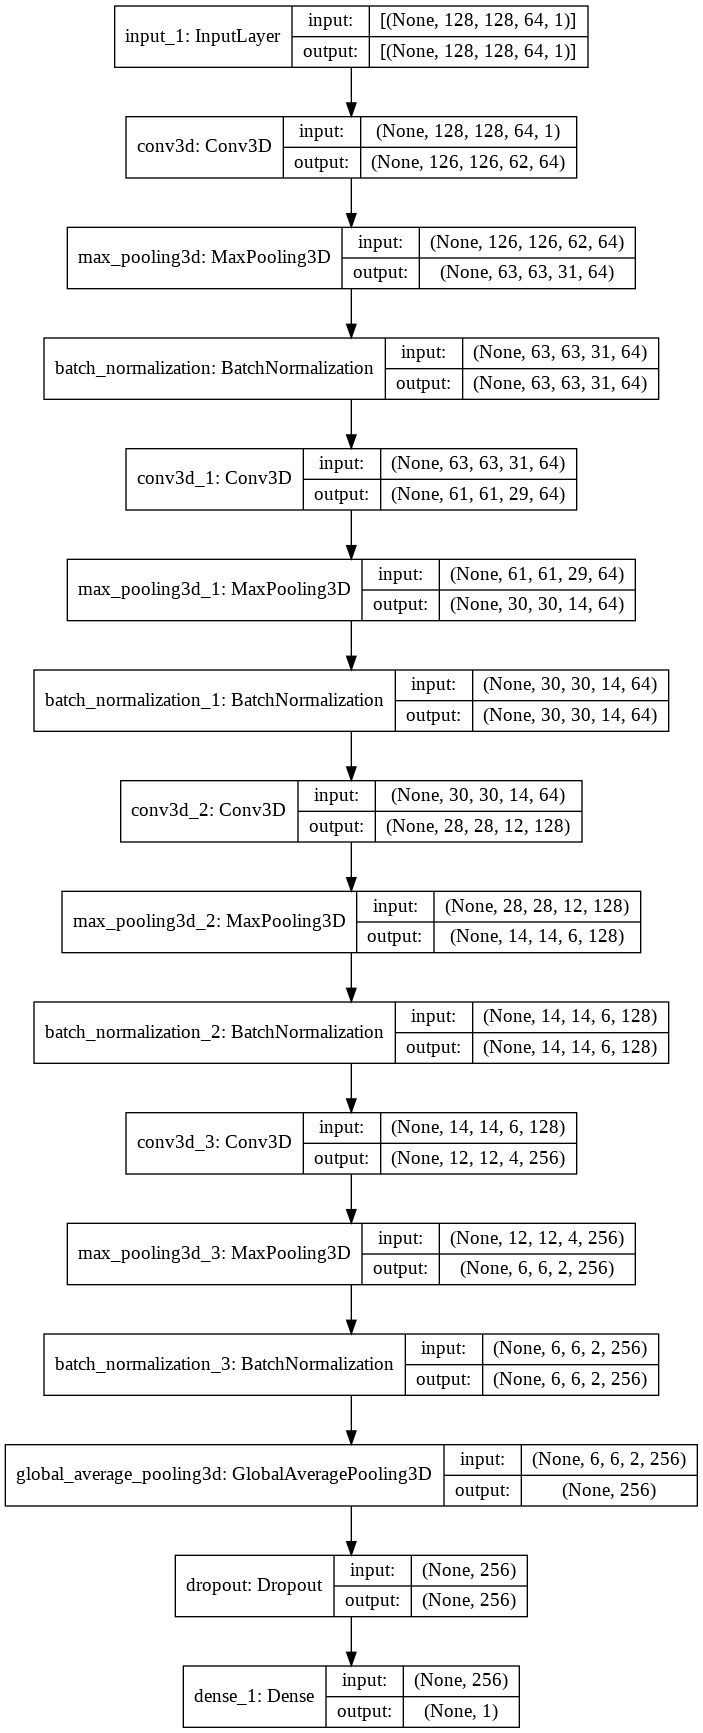

In [ ]:
model = get_model()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.96, staircase=True
)
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['acc']
)
checkpoint_cb = ModelCheckpoint('/content/gdrive/MyDrive/Colab_Datasets/3DCNN_model.h5', save_best_only=True)

early_stopping_clbck = EarlyStopping(monitor='val_acc', patience=15)
epochs=100
model.fit(
    train_dataset, 
    validation_data = validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks = [checkpoint_cb, early_stopping_clbck]
)

Epoch 1/100
70/70 - 38s - loss: 1.0672 - acc: 0.5929 - val_loss: 0.8385 - val_acc: 0.6500
Epoch 2/100
70/70 - 36s - loss: 1.0456 - acc: 0.5714 - val_loss: 0.5724 - val_acc: 0.6500
Epoch 3/100
70/70 - 36s - loss: 0.9978 - acc: 0.5714 - val_loss: 5.1415 - val_acc: 0.5000
Epoch 4/100
70/70 - 36s - loss: 0.9283 - acc: 0.6000 - val_loss: 2.6901 - val_acc: 0.5000
Epoch 5/100
70/70 - 36s - loss: 0.9585 - acc: 0.5786 - val_loss: 0.9040 - val_acc: 0.6000
Epoch 6/100
70/70 - 36s - loss: 0.8169 - acc: 0.6143 - val_loss: 0.8099 - val_acc: 0.6167
Epoch 7/100
70/70 - 36s - loss: 0.7690 - acc: 0.5857 - val_loss: 4.4255 - val_acc: 0.5000
Epoch 8/100
70/70 - 36s - loss: 0.8798 - acc: 0.5357 - val_loss: 0.6659 - val_acc: 0.6833
Epoch 9/100
70/70 - 36s - loss: 0.7264 - acc: 0.5714 - val_loss: 0.9999 - val_acc: 0.6333
Epoch 10/100
70/70 - 36s - loss: 0.6441 - acc: 0.6643 - val_loss: 1.0251 - val_acc: 0.5667
Epoch 11/100
70/70 - 36s - loss: 0.7277 - acc: 0.6143 - val_loss: 1.0528 - val_acc: 0.5167
Epoch 12

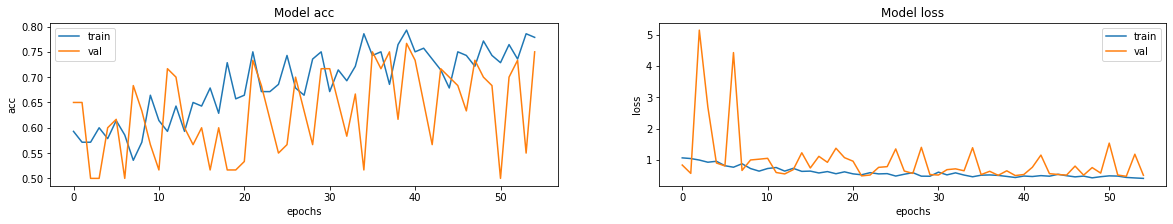

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

This model is 9.78 percent confident that CT scan is normal
This model is 90.22 percent confident that CT scan is abnormal
The actual prediction is: abnormal


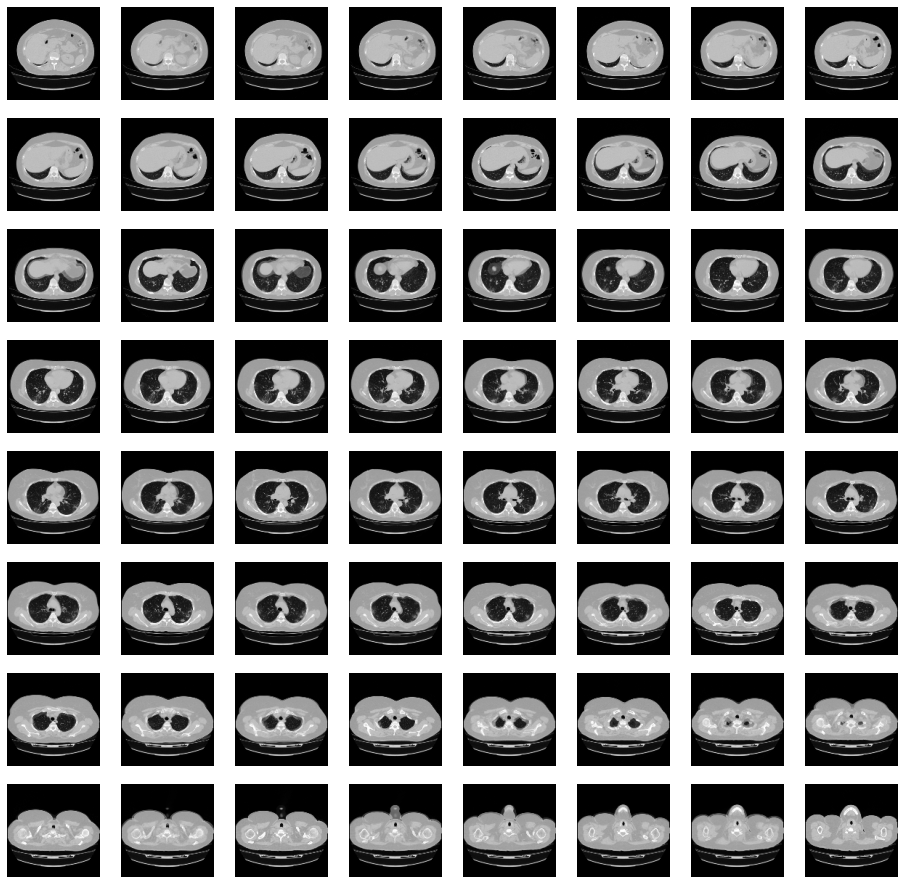

In [18]:
model.load_weights("/content/gdrive/MyDrive/Colab_Datasets/3DCNN_model.h5")
# prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )
plot_slices2(8,8, x_val[0])
print('The actual prediction is:', class_names[y_val[0]])